In [2]:
import json, pandas as pd, requests, os,  matplotlib.pyplot as plt
from datetime import datetime
# Load environment variables from .env file
from dotenv import load_dotenv
load_dotenv()

True


#TODO are we allowed to display any of this data on a public website if I need admin privileges to get the data?

#TODO add all of the necessary packages which have been installed in the conda env into the projects python environment requirements.txt for Docker

## API Users

In [5]:
# Read in run data through FY24 from saved API response
with open('api_users_thru_FY24.json', 'r') as file:
    previous_users = json.load(file)

previous_users_df = pd.DataFrame(previous_users["data"])

# Call api.data.gov API for latest users which were not stored in the local file (up through 2024-09-30)
users_api_response = get_api_gov_data(api_or_jl="api", users_or_runs="users", start_date="2024-10-01", end_date=datetime.today().strftime('%Y-%m-%d'), interval="month")
latest_users_df = pd.DataFrame(users_api_response["data"])

# Append latest_users to previous_users_df to get full history of users up to latest
users = pd.concat([previous_users_df, latest_users_df], ignore_index=True)


API response successfully parsed.


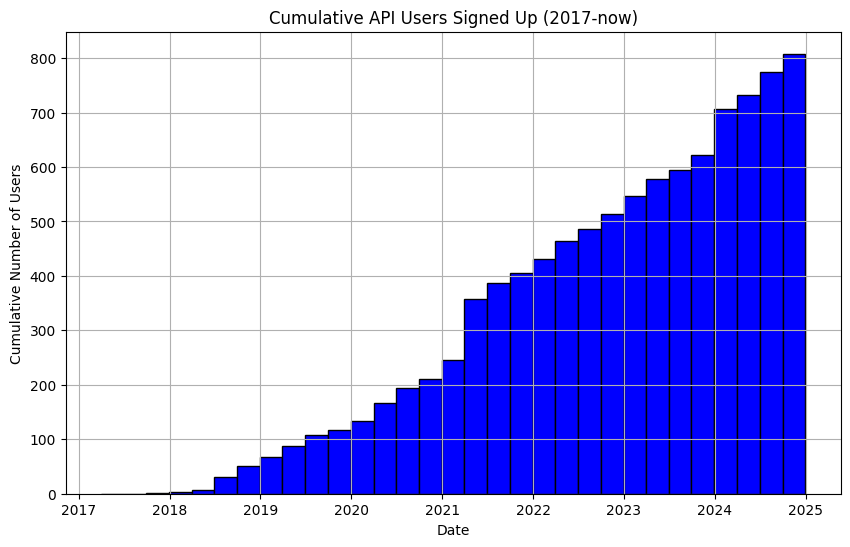

In [6]:
# Cumulative users signed up
# Convert the "created_at" column to datetime
users['created_at'] = pd.to_datetime(users['created_at'])

# Filter users who signed up from 2017 through 2024
filtered_users = users[(users['created_at'] >= '2017-01-01') & (users['created_at'] <= '2024-12-31')]

# Plot the histogram with the specified bar width
plt.figure(figsize=(10, 6))
plt.hist(filtered_users['created_at'], bins=pd.date_range(start='2017-01-01', end='2025-01-01', freq='QE'), cumulative=True, color='blue', edgecolor='black')
plt.title('Cumulative API Users Signed Up (2017-now)')
plt.xlabel('Date')
plt.ylabel('Cumulative Number of Users')
plt.grid(True)
plt.show()

/tmp/ipykernel_70496/2001765266.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_last_request.loc[:, 'Fiscal Year'] = filtered_last_request['last_request_at'].apply(lambda x: x.year if x.month < 10 else x.year + 1)


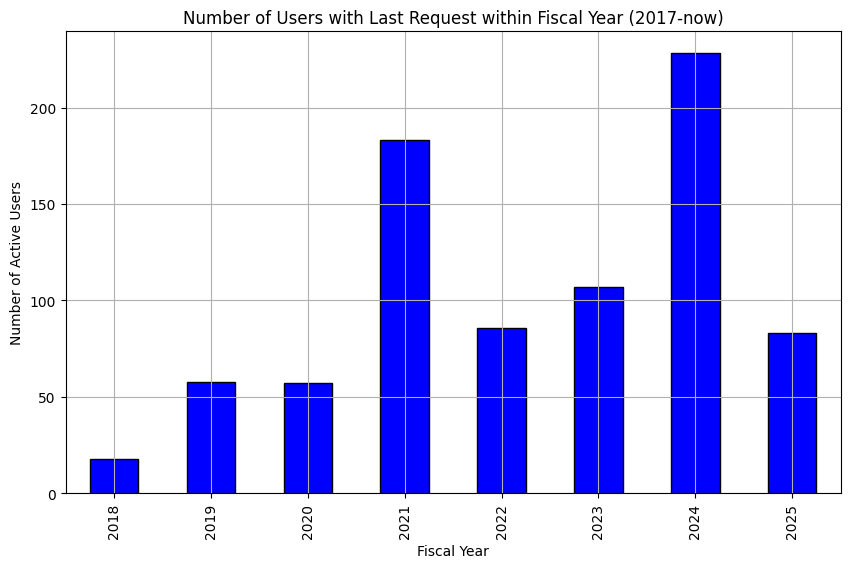

In [7]:
# Active API users in each fiscal year
# Convert the "last_request_at" column to datetime
users['last_request_at'] = pd.to_datetime(users['last_request_at'])

# Filter users who have "last_request_at" within the fiscal year
filtered_last_request = users.loc[(users['last_request_at'] >= '2016-10-01') & (users['last_request_at'] <= datetime.today().strftime('%Y-%m-%d'))]

# Extract fiscal year from "Last Request (UTC)"
filtered_last_request.loc[:, 'Fiscal Year'] = filtered_last_request['last_request_at'].apply(lambda x: x.year if x.month < 10 else x.year + 1)

# Count the number of users per fiscal year
user_counts = filtered_last_request['Fiscal Year'].value_counts().sort_index()

# Plot the bar chart
plt.figure(figsize=(10, 6))
user_counts.plot(kind='bar', color='blue', edgecolor='black')
plt.title('Number of Users with Last Request within Fiscal Year (2017-now)')
plt.xlabel('Fiscal Year')
plt.ylabel('Number of Active Users')
plt.grid(True)
plt.show()

## API Runs (POST to /job)

In [8]:
# Read in run data through FY24
with open('api_run_data_thru_FY24.json', 'r') as file:
    previous_runs_json = json.load(file)

# Call api.data.gov API for user or run data
latest_runs_json = get_api_gov_data(api_or_jl="api", users_or_runs="runs", start_date="2024-10-01", end_date=datetime.today().strftime('%Y-%m-%d'), interval="month")

# Concatenate previous and latest run data
all_runs = previous_runs_json["hits_over_time"]["rows"] + latest_runs_json["hits_over_time"]["rows"]


API response successfully parsed.


In [9]:
runs_arr = []
run_date_range = []
for c in range(len(all_runs)):
    run_c = all_runs[c]["c"]
    runs_arr.append(sum([run_c[v]["v"] for v in range(1, len(run_c))]))
    run_date_range.append(run_c[0]["f"])

# Convert elements of run_date_range to datetime objects
run_date_range_dt = [datetime.strptime(date_range.split(' - ')[0], '%b %d, %Y') for date_range in run_date_range]

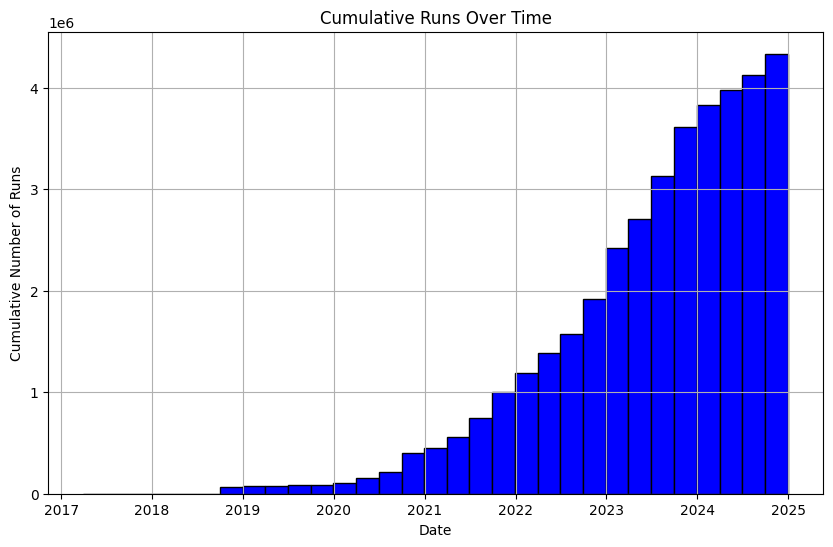

In [10]:
# Plot the cumulative histogram
plt.figure(figsize=(10, 6))
plt.hist(run_date_range_dt, bins=pd.date_range(start='2017-01-01', end='2025-01-01', freq='QE'), weights=runs_arr, cumulative=True, color='blue', edgecolor='black')
plt.title('Cumulative Runs Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Number of Runs')
plt.grid(True)
plt.show()

## Julia package users and runs, of which some runs would also contain API runs above
#### but the API runs can be filtered out by taking out the reopt-api-wind-toolkit.api_keys@nrel.gov user
#### also, older versions of REopt.jl that are still in-use would not require the user's API_key, and would instead use: nick.laws@nrel.gov which was also the old test API_key
#### laws.nick@gmail.com is the current REopt.jl test API_key for GitHub Actions

In [11]:
# Call api.data.gov API for user or run data
response = get_api_gov_data(api_or_jl="jl", users_or_runs="users", start_date="2022-10-01", end_date=datetime.today().strftime('%Y-%m-%d'), interval="month")

# Convert the list of dictionaries of response["data"] into a dataframe
reoptjl_users = pd.DataFrame(response["data"])

API response successfully parsed.


NOTE, prior to Jan 2024, user's were not required to use their own API key


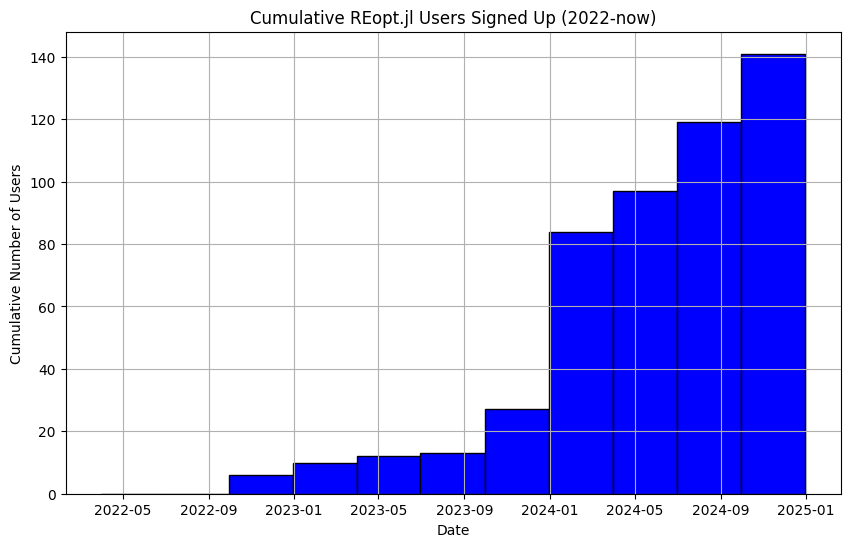

In [13]:
# Cumulative users signed up
# Convert the "Signed Up (UTC)" column to datetime
reoptjl_users['created_at'] = pd.to_datetime(reoptjl_users['created_at'])

# Filter users who signed up from 2017 through 2024
filtered_users = reoptjl_users[reoptjl_users['created_at'] >= '2022-10-01']

# Plot the histogram with the specified bar width
plt.figure(figsize=(10, 6))
plt.hist(filtered_users['created_at'], bins=pd.date_range(start='2022-01-01', end='2025-01-01', freq='QE'), cumulative=True, color='blue', edgecolor='black')
plt.title('Cumulative REopt.jl Users Signed Up (2022-now)')
plt.xlabel('Date')
plt.ylabel('Cumulative Number of Users')
plt.grid(True)
print("NOTE, prior to Jan 2024, user's were not required to use their own API key")
plt.show()

NOTE, prior to Jan 2024, user's were not required to use their own API key


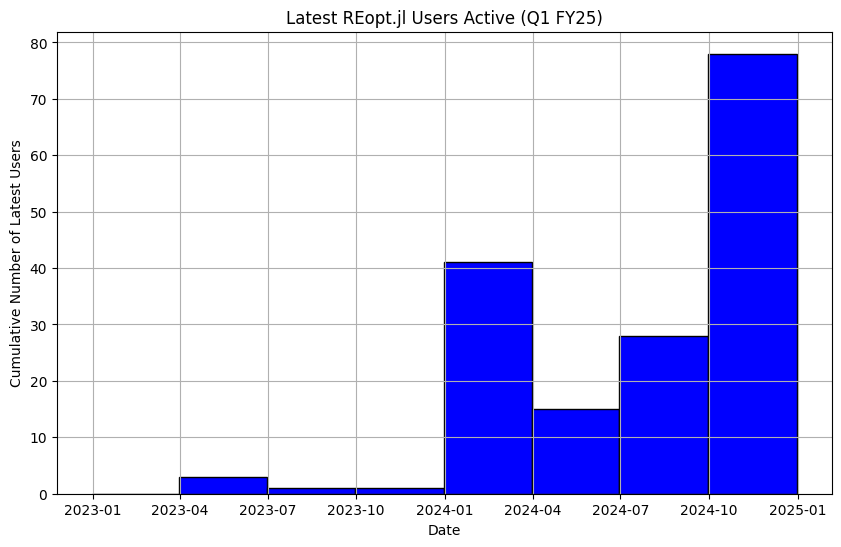

In [195]:
# Active users
# Convert the "Last Request" column to datetime
reoptjl_users['last_request_at'] = pd.to_datetime(reoptjl_users['last_request_at'])

# Filter users who signed up from 2017 through 2024
filtered_users = reoptjl_users[(reoptjl_users['last_request_at'] >= '2022-10-01') & (reoptjl_users['last_request_at'] <= '2024-12-31')]

# Plot the histogram with the specified bar width
plt.figure(figsize=(10, 6))
plt.hist(filtered_users['last_request_at'], bins=pd.date_range(start='2022-10-01', end='2025-01-01', freq='QE'), cumulative=False, color='blue', edgecolor='black')
plt.title('Latest REopt.jl Users Active (Q1 FY25)')
plt.xlabel('Date')
plt.ylabel('Cumulative Number of Latest Users')
plt.grid(True)
print("NOTE, prior to Jan 2024, user's were not required to use their own API key")
plt.show()

## REopt.jl runs history

In [188]:
# Call api.data.gov API for user or run data
response = get_api_gov_data(api_or_jl="jl", users_or_runs="runs", start_date="2022-10-01", end_date=datetime.today().strftime('%Y-%m-%d'), interval="month")

API response successfully parsed.


In [189]:
runs_arr = []
run_date_range = []
for c in range(len(response["hits_over_time"]["rows"])):
    run_c = response["hits_over_time"]["rows"][c]["c"]
    runs_arr.append(sum([run_c[v]["v"] for v in range(1, len(run_c))]))
    run_date_range.append(run_c[0]["f"])

# Convert elements of run_date_range to datetime objects
run_date_range_dt = [datetime.strptime(date_range.split(' - ')[0], '%b %d, %Y') for date_range in run_date_range]

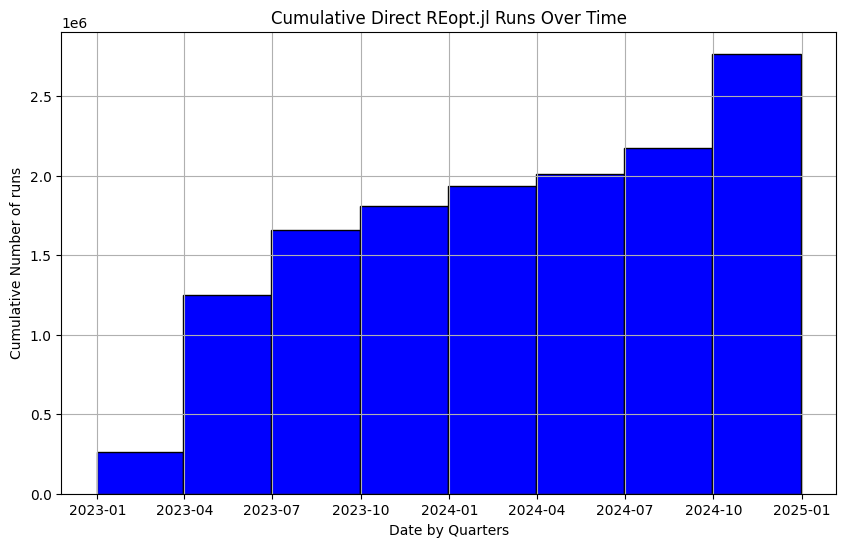

In [194]:
# Plot the cumulative histogram
plt.figure(figsize=(10, 6))
plt.hist(run_date_range_dt, bins=pd.date_range(start='2022-10-01', end='2025-01-01', freq='QE'), weights=runs_arr, cumulative=True, color='blue', edgecolor='black')
plt.title('Cumulative Direct REopt.jl Runs Over Time')
plt.xlabel('Date by Quarters')
plt.ylabel('Cumulative Number of runs')
plt.grid(True)
plt.show()

In [4]:
def get_api_gov_data(*, api_or_jl, users_or_runs, start_date, end_date=datetime.today().strftime('%Y-%m-%d'), interval="month"):
    # Update default query for API vs REopt.jl -> PVWatts and Users vs Runs data
    if api_or_jl == "api":
        if users_or_runs == "users":
            query = '%7B"condition"%3A"AND"%2C"rules"%3A%5B%7B"id"%3A"request_path"%2C"field"%3A"request_path"%2C"type"%3A"string"%2C"input"%3A"text"%2C"operator"%3A"contains"%2C"value"%3A"reopt"%7D%5D%2C"valid"%3Atrue%7D'
            base_url = "https://api.data.gov/admin/stats/users.json?"
        elif users_or_runs == "runs":
            prefix = '3%2Fdeveloper.nrel.gov%2Fapi%2Freopt%2F'
            query = '%7B"condition"%3A"AND"%2C"rules"%3A%5B%7B"id"%3A"request_path"%2C"field"%3A"request_path"%2C"type"%3A"string"%2C"input"%3A"text"%2C"operator"%3A"contains"%2C"value"%3A"%2Fjob"%7D%2C%7B"id"%3A"request_method"%2C"field"%3A"request_method"%2C"type"%3A"string"%2C"input"%3A"select"%2C"operator"%3A"equal"%2C"value"%3A"post"%7D%5D%2C"valid"%3Atrue%7D'
            base_url = "https://api.data.gov/api-umbrella/v1/analytics/drilldown.json?prefix=" + prefix 
        else:
            print("Error: Invalid users_or_runs. Please specify either 'users' or 'runs'.")
    elif api_or_jl == "jl":
        if users_or_runs == "users":
            query = '%7B"condition"%3A"AND"%2C"rules"%3A%5B%7B"id"%3A"request_path"%2C"field"%3A"request_path"%2C"type"%3A"string"%2C"input"%3A"text"%2C"operator"%3A"contains"%2C"value"%3A"pvwatts"%7D%2C%7B"id"%3A"request_user_agent"%2C"field"%3A"request_user_agent"%2C"type"%3A"string"%2C"input"%3A"text"%2C"operator"%3A"contains"%2C"value"%3A".jl"%7D%5D%2C"valid"%3Atrue%7D'
            base_url = "https://api.data.gov/admin/stats/users.json?"
        elif users_or_runs == "runs":
            prefix = '3%2Fdeveloper.nrel.gov%2Fapi%2Fpvwatts%2F'
            # query = '%7B"condition"%3A"AND"%2C"rules"%3A%5B%7B"id"%3A"request_user_agent"%2C"field"%3A"request_user_agent"%2C"type"%3A"string"%2C"input"%3A"text"%2C"operator"%3A"contains"%2C"value"%3A".jl"%7D%5D%2C"valid"%3Atrue%7D'
            # Do NOT include the REopt_API user reopt-api-wind-toolkit.api_keys@nrel.gov and the REopt.jl GitHub Actions tests user laws.nick@nrel.gov
            query = '%7B"condition"%3A"AND"%2C"rules"%3A%5B%7B"id"%3A"request_user_agent"%2C"field"%3A"request_user_agent"%2C"type"%3A"string"%2C"input"%3A"text"%2C"operator"%3A"contains"%2C"value"%3A".jl"%7D%2C%7B"id"%3A"user_email"%2C"field"%3A"user_email"%2C"type"%3A"string"%2C"input"%3A"text"%2C"operator"%3A"not_contains"%2C"value"%3A"reopt-api-wind-toolkit.api_keys%40nrel.gov"%7D%2C%7B"id"%3A"user_email"%2C"field"%3A"user_email"%2C"type"%3A"string"%2C"input"%3A"text"%2C"operator"%3A"not_contains"%2C"value"%3A"laws.nick%40gmail.com"%7D%5D%2C"valid"%3Atrue%7D'
            base_url = "https://api.data.gov/api-umbrella/v1/analytics/drilldown.json?prefix=" + prefix 
        else:
            print("Error: Invalid users_or_runs. Please specify either 'users' or 'runs'.")       
    else:
        print("Error: Invalid api_or_jl. Please specify either 'api' or 'jl'.")

    # Expects these ENV variables to be set
    headers = {
        "X-Admin-Auth-Token": os.getenv('ADMIN_AUTH_TOKEN'),
        "X-Api-Key": os.getenv('API_KEY')
    }

    # Note: the base URL already contains a "?" character and if applicable, the prefix, so we need and "&" character for the first parameter "query" here
    jobs_url = base_url + \
        "&query=" + query + \
            "&start_at=" + start_date + \
                "&end_at=" + end_date + \
                    "&interval=" + interval
    
    r = requests.get(jobs_url, headers=headers)

    if r.status_code == 200:
        try:
            response = r.json()
            print("API response successfully parsed.")
        except json.JSONDecodeError:
            print("Error: Failed to parse JSON response.")
    else:
        print(f"Error: Received status code {r.status_code}")
        print(r.text)

    return response


In [4]:
# Try POSTing to /simulated_load endpoint

import json
import requests

url = "https://norm-scale-load-reopt-stage-api.its.nrel.gov/stable/simulated_load/"

# Load the sim_post.json file
with open('sim_post.json', 'r') as file:
    sim_post_data = json.load(file)

# Perform the POST request
response = requests.post(url, json=sim_post_data) #, headers={"X-Api-Key": os.getenv('API_KEY')})

# Check the response
if response.status_code == 200:
    print("POST request successful.")
    print(response.json())
else:
    print(f"Error: Received status code {response.status_code}")
    print(response.text)

POST request successful.
{'annual_mmbtu': 1000.0, 'min_mmbtu_per_hour': 0.0, 'loads_mmbtu_per_hour': [0.318, 0.331, 0.33, 0.33, 0.33, 0.328, 0.326, 0.317, 0.252, 0.164, 0.109, 0.071, 0.054, 0.053, 0.051, 0.053, 0.084, 0.128, 0.177, 0.215, 0.236, 0.251, 0.264, 0.27, 0.26, 0.271, 0.276, 0.288, 0.293, 0.292, 1.095, 1.126, 0.705, 0.695, 0.562, 0.245, 0.46, 0.067, 0.044, 0.072, 0.163, 0.541, 0.278, 0.317, 0.44, 0.468, 0.0, 0.0, 0.004, 0.01, 0.016, 0.028, 0.041, 0.044, 3.186, 1.584, 0.669, 0.377, 0.234, 0.154, 0.535, 0.253, 0.374, 0.563, 0.768, 1.344, 0.267, 0.294, 0.407, 0.451, 0.002, 0.021, 0.054, 0.093, 0.143, 0.176, 0.194, 0.202, 3.139, 1.202, 0.738, 0.754, 0.532, 0.352, 0.477, 0.02, 0.006, 0.005, 0.027, 0.252, 0.178, 0.191, 0.274, 0.291, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.557, 0.981, 0.023, 0.003, 0.0, 0.0, 0.0, 0.0, 0.0, 0.001, 0.062, 0.297, 0.026, 0.045, 0.107, 0.146, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.323, 2.114, 0.626, 0.558, 0.523, 0.46, 0.732, 0.42, 0.401, 0.428, 0.5